In [47]:
import pandas as pd
import os
import pickle
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans


# Botnet	fingerprinting task

First, we create a function to read our data

In [4]:
# columns = StartTime, Dur, Proto, SrcAddr, Sport, Dir, DstAddr, Dport, State, sTos, dTos, TotPkts, TotBytes, SrcBytes, Label

scenario_size = [(1,368), (2,235), (3,610), (4,146), (5,17), (6,73), (7,15), (8,385), (9,272), (11,14), (12,43), (13,250)]
scenarios = [t[0] for t in sorted(scenario_size, key=lambda x: x[1])]
print(scenarios)

def read_from_file(scenario):
    print("Reading from file. Scenario: %s" % scenario)

    # Get the path of the file
    dir_path = os.path.join( "data", "CTU-13-Dataset", str(scenario))
    file_name = filter(lambda x: x.endswith(".binetflow"), os.listdir(dir_path))[0]
    file_path = os.path.join(dir_path, file_name)

    # Read the csv file in a pandas dataframe
    # Convert label: "flow=From-Botnet" to 1, label: "flow=From-Normal" to 0 and the rest to 2
    converters = {"Label": lambda x: 1 if x.startswith("flow=From-Botnet") else (0 if x.startswith("flow=From-Normal") else 2)}
    df = pd.read_csv(file_path, skip_blank_lines=True, delimiter=",", converters=converters)

    # Drop rows that contain null values for atleast one of these rows: "DstAddr", "SrcAddr", "Dport", "Sport", "Label"
    df.dropna(subset=["DstAddr", "SrcAddr", "Dport", "Sport", "Label"], inplace=True, how="any")

    # remove the background flows
    df = df[df.Label != 2]

    print("\tDone!!")
    return df

[11, 7, 5, 12, 6, 4, 2, 13, 9, 1, 8, 3]


In [15]:
# Read a scenario

# Here, we test scenario 1
# Any other scenario could be selected

scenario = 1

df = read_from_file(scenario)

Reading from file. Scenario: 1
	Done!!


### First	cluster	the	NetFlows	using	a	clustering	method	of	your	choice	in	order	to	discretize	the	data

The method we chose to cluster the NetFlows is K-means.

The columns which contrain non numerical values and need to be mapped are: "Proto" {udp,tcp,icmp} and "direction" {'   ->' '  <->' '  <?>' '   ?>'}.

To use them with the K-Means algorithm we convert the categorical values to dummy types


In [76]:
# Remove the columns which will not be used the clustering
# sTos, dTos (Nan and 0 values)

df_clust = df.drop(["sTos","dTos", "State", "DstAddr", "Sport", "Dport"], 1)

print list(df_clust)
#print df_clust["Sport"].nunique()


['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Dir', 'TotPkts', 'TotBytes', 'SrcBytes', 'Label']


In [77]:
# Create dummy types
df_dum = pd.get_dummies(df_clust, columns = ["Proto","Dir"])
print list(df_dum)

['StartTime', 'Dur', 'SrcAddr', 'TotPkts', 'TotBytes', 'SrcBytes', 'Label', 'Proto_icmp', 'Proto_tcp', 'Proto_udp', 'Dir_   ->', 'Dir_   ?>', 'Dir_  <->', 'Dir_  <?>']


In [126]:
# Group by labels
df_group_by_label = df_dum.groupby("Label")

# Get records of infected IPs.
df_inf = df_group_by_label.get_group(1)

# Get records of non-infected IPs
df_non_inf = df_group_by_label.get_group(0)

# Group by SrcAddr the infected IPs
df_inf = df_inf.groupby(["SrcAddr"])

# Group by SrcAddr the non infected IPs
df_non_inf = df_non_inf.groupby(["SrcAddr"])

# If multiple infected IPs, take the first
df_inf = df_inf.get_group(df_inf.groups.keys()[0])


df_inf

,StartTime,Dur,SrcAddr,TotPkts,TotBytes,SrcBytes,Label,Proto_icmp,Proto_tcp,Proto_udp,Dir_ ->,Dir_ ?>,Dir_ <->,Dir_ <?>
675613,2011/08/10 11:04:24.863449,0.000278,147.32.84.165,2,203,64,1,0,0,1,0,0,1,0
675948,2011/08/10 11:04:27.118993,0.020525,147.32.84.165,2,590,87,1,0,0,1,0,0,1,0
675953,2011/08/10 11:04:27.140727,0.045125,147.32.84.165,7,882,629,1,0,1,0,1,0,0,0
690001,2011/08/10 11:06:23.268442,0.336250,147.32.84.165,2,215,71,1,0,0,1,0,0,1,0
690036,2011/08/10 11:06:23.606888,3514.083496,147.32.84.165,120,7767,2690,1,0,1,0,1,0,0,0
691744,2011/08/10 11:06:36.076294,0.459301,147.32.84.165,2,212,77,1,0,0,1,0,0,1,0
691823,2011/08/10 11:06:36.536447,0.216252,147.32.84.165,37,27990,1046,1,0,1,0,1,0,0,0
691960,2011/08/10 11:06:37.477233,1.371909,147.32.84.165,3,295,156,1,0,0,1,0,0,1,0
692124,2011/08/10 11:06:38.849594,2.568064,147.32.84.165,72,60278,1897,1,0,1,0,1,0,0,0
692271,2011/08/10 11:06:40.383196,0.313117,147.32.84.165,2,202,72,1,0,0,1,0,0,1,0


In [80]:
# convert to numpy array
clust_cols = list(df_inf)
clust_cols.remove("StartTime")
clust_cols.remove("SrcAddr")
clust_cols.remove("Label")

num_inf = df_inf.as_matrix(columns = clust_cols)
print num_inf
    

[[  2.78000000e-04   2.00000000e+00   2.03000000e+02 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  2.05250000e-02   2.00000000e+00   5.90000000e+02 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  4.51250000e-02   7.00000000e+00   8.82000000e+02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  4.05000000e-04   2.00000000e+00   1.38000000e+02 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  5.68700000e-02   2.00000000e+00   1.44000000e+02 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  5.52940000e-02   2.00000000e+00   2.04000000e+02 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]]


###  Use	the	“ELBOW”	method	to	determine	the	number	of	clusters

After all that, we are now ready to **cluster**!
To define the optimal number of clusters we used the Elbow method [https://en.wikipedia.org/wiki/Elbow_method_(clustering)]

The below code provides a diagram on which the sum of distances of samples to their closest cluster center over the number of the clusters is plotted.

This diagram suggests that the best number of clusters is six.




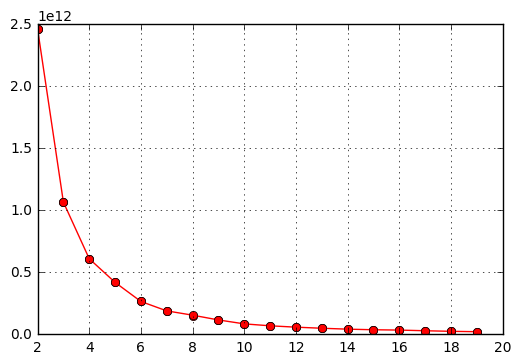

In [91]:
import matplotlib.pyplot as plt

elbow = []
num_clust = []
for clusts in range(2,20):
    kmeans = KMeans(n_clusters=clusts).fit(num_inf)
    elbow.append(kmeans.inertia_)
    num_clust.append(clusts)

plt.plot(num_clust, elbow,"-ro")
plt.grid(True)

plt.show()


Thus, we use 6 clusters to cluster our data. Obviously, if you run another scenario you should change the number of clusters according to the resulted diagram.

In [120]:
from collections import Counter as Counter
kmeans = KMeans(n_clusters = 6).fit(num_inf)
kmeans.labels_
kmeans.cluster_centers_
#Counter(kmeans.labels_)


array([[  9.87708670e+00,   2.73249798e+00,   3.35622422e+02,
          1.41761335e+02,   4.90424462e-05,   2.83857679e-01,
          7.16093279e-01,   3.58868100e-01,   0.00000000e+00,
          6.41131900e-01,   0.00000000e+00],
       [  1.62920173e+02,   3.72878788e+02,   1.78863697e+05,
          1.61991909e+05,   2.03287907e-20,   1.00000000e+00,
         -3.33066907e-16,   1.00000000e+00,   0.00000000e+00,
         -1.11022302e-16,   0.00000000e+00],
       [  3.37618953e+03,   5.71400000e+03,   4.68403500e+05,
          2.09976000e+05,  -6.77626358e-21,   1.00000000e+00,
         -1.11022302e-16,   1.00000000e+00,   0.00000000e+00,
         -1.11022302e-16,   0.00000000e+00],
       [  3.71631888e+02,   2.82767442e+02,   1.79218791e+05,
          9.59267442e+03,   3.38813179e-20,   1.00000000e+00,
         -3.33066907e-16,   1.00000000e+00,   0.00000000e+00,
         -4.44089210e-16,   0.00000000e+00],
       [  2.43145136e+03,   9.24666667e+02,   6.88309000e+05,
          7.42

In [ ]:
# For each Src Addr. of the non infected hosts take each record and assign the 
# cluster which is more similar to the infected clusters.

for key in df_non_inf:
    non_inf_records = df_non_inf.get_group(key)
    